In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import pywt
import heartpy as hp
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, resample
from scipy import signal

from detect_body_movements import detect_patterns
from band_pass_filtering import band_pass_filtering
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
import math
from remove_nonLinear_trend import remove_nonLinear_trend
from compute_vitals import vitals

%matplotlib inline

In [2]:


# SYNC
def build_bcg_df(bcg_values, initial_timestamp, fs):
    """
    Constructs a BCG DataFrame from raw values, initial timestamp, and sampling rate.
    
    Args:
        bcg_values: List of BCG signal values (e.g., [-86, -90, -91, -86])
        initial_timestamp: Timestamp of first sample (epoch ms or datetime string)
        fs: Sampling frequency in Hz
        
    Returns:
        pd.DataFrame with columns: ['Timestamp', 'BCG', 'Time']
    """
    # Convert timestamp to datetime if it's a string
    if isinstance(initial_timestamp, str):
        initial_timestamp = pd.to_datetime(initial_timestamp)
    elif isinstance(initial_timestamp, (int, float)):
        initial_timestamp = pd.to_datetime(initial_timestamp, unit='ms')
    
    # Calculate time intervals
    period = 1 / fs
    timestamps = [initial_timestamp + pd.Timedelta(seconds=i*period) 
                 for i in range(len(bcg_values))]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'BCG': bcg_values
    })
    
    # Add human-readable time
    df['Time'] = df['Timestamp'].dt.strftime('%H:%M:%S.%f')
    
    return df




def synchronize_bcg_and_hr(df_bcg_raw, df_hr_raw):
    """
    Builds and synchronizes BCG and HR DataFrames starting from the first common time.
    
    Args:
        df_bcg_raw: Raw BCG DataFrame from CSV. Must contain 'BCG', 'Timestamp', and 'fs' columns.
        df_hr_raw: Raw HR DataFrame from CSV. Must contain 'Timestamp' column in datetime-compatible format.
    
    Returns:
        bcg_aligned, hr_aligned: Time-synchronized DataFrames
    """
        # Parse BCG values and metadata
    bcg_values = df_bcg_raw['BCG'].tolist()
    initial_timestamp = pd.to_datetime(df_bcg_raw.loc[0, 'Timestamp'], unit='ms')
    fs = float(df_bcg_raw.loc[0, 'fs'])

    # Build BCG DataFrame
    df_bcg = build_bcg_df(bcg_values, initial_timestamp, fs)

    # Parse HR timestamps
    df_hr_raw['Timestamp'] = pd.to_datetime(df_hr_raw['Timestamp'])

    # Find common time range
    start_time = max(df_bcg['Timestamp'].min(), df_hr_raw['Timestamp'].min())
    end_time = min(df_bcg['Timestamp'].max(), df_hr_raw['Timestamp'].max())

    # Trim both DataFrames to common range
    bcg_aligned = df_bcg[(df_bcg['Timestamp'] >= start_time) & (df_bcg['Timestamp'] <= end_time)].copy()
    hr_aligned = df_hr_raw[(df_hr_raw['Timestamp'] >= start_time) & (df_hr_raw['Timestamp'] <= end_time)].copy()

    # Reset index
    bcg_aligned.reset_index(drop=True, inplace=True)
    hr_aligned.reset_index(drop=True, inplace=True)

    return bcg_aligned, hr_aligned






In [3]:
# Windowing


def create_time_windows(df, time_col, window_col, window_length_sec=10, shift_sec=1):
    """
    Splits the DataFrame into overlapping time-based windows.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a datetime column.
        time_col (str): Name of the timestamp column (must be datetime type).
        window_col (str): Name of the column to include in the output (e.g., 'BCG').
        window_length_sec (int): Length of each window in seconds.
        shift_sec (int): Amount of shift between windows in seconds.

    Returns:
        List[pd.DataFrame]: List of DataFrames, each representing a time window.
    """
    window_length = pd.Timedelta(seconds=window_length_sec)
    window_shift = pd.Timedelta(seconds=shift_sec)
    
    start_time = df[time_col].min()
    end_time = df[time_col].max()
    
    windows = []
    
    while start_time + window_length <= end_time:
        window_df = df[(df[time_col] >= start_time) & 
                       (df[time_col] < start_time + window_length)][[time_col, window_col]]
        if not window_df.empty:
            windows.append(window_df)
        start_time += window_shift
    
    return windows






In [4]:
# s4 wavelet decomp

def decompose_wavelet(signal_series, wavelet='db4', level=4):
    """
    Performs multi-level wavelet decomposition on a signal.

    Parameters:
        signal_series (pd.Series or list-like): The 1D input signal.
        wavelet (str): The name of the wavelet to use (e.g., 'db4').
        level (int): The number of decomposition levels.

    Returns:
        Tuple: (approximation, details...) where:
            - approximation: The final approximation coefficients (e.g., S4)
            - details: List of detail coefficients (e.g., [D4, D3, D2, D1])
    """
    coeffs = pywt.wavedec(signal_series, wavelet, level=level)
    approximation = coeffs[0]
    details = coeffs[1:]
    return approximation, details


In [5]:

# Resampling the signal to 50 Hz
def resample_to_50hz(signal_series, target_fs=50, duration_sec=10):
    """
    Resample the signal to a target frequency (50 Hz).

    Parameters:
        signal_series (pd.Series or list-like): The input signal.
        target_fs (int): The target frequency (50 Hz).
        duration_sec (int): Duration of the signal in seconds (e.g., 10 seconds).

    Returns:
        np.ndarray: Resampled signal.
    """
    target_samples = target_fs * duration_sec  # e.g., 500 samples for 10s
    return resample(signal_series, target_samples)

In [6]:
def resample_bcg(bcg_data, original_fs=140, target_fs=50):
    """
    Resample BCG data from original_fs to target_fs and update timestamps
    
    Args:
        bcg_data: DataFrame containing BCG data with 'Timestamp' and 'BCG' columns
        original_fs: Original sampling frequency (default 140 Hz)
        target_fs: Target sampling frequency (default 50 Hz)
    
    Returns:
        Resampled DataFrame with updated timestamps
    """
    # Calculate the resampling factor
    num_samples = len(bcg_data)
    new_num_samples = int(num_samples * target_fs / original_fs)
    
    # Resample the signal
    bcg_signal = bcg_data['BCG'].values
    
    # Convert timestamps to numerical values (nanoseconds since epoch)
    timestamps_ns = bcg_data['Timestamp'].astype(np.int64).values
    start_time_ns = timestamps_ns[0]
    end_time_ns = timestamps_ns[-1]
    
    # Resample both signal and timestamps
    resampled_signal = signal.resample(bcg_signal, new_num_samples)
    resampled_timestamps_ns = np.linspace(start_time_ns, end_time_ns, new_num_samples)
    
    # Convert back to datetime
    resampled_timestamps = pd.to_datetime(resampled_timestamps_ns)
    
    # Create new DataFrame
    resampled_df = pd.DataFrame({
        'Timestamp': resampled_timestamps,
        'BCG': resampled_signal
    })
    
    return resampled_df


In [7]:

#read csv files
df_bcg= pd.read_csv('/home/bahey/bio_data/dataset/data/01/BCG/01_20231105_BCG.csv')        #### n4 &
df_heart=pd.read_csv("/home/bahey/bio_data/dataset/data/01/Reference/RR/01_20231105_RR.csv")   #### 1 second one

# step 1 :Synchronize BCG and HR DataFrames from the first common time
bcg_sync, hr_sync = synchronize_bcg_and_hr(df_bcg, df_heart)

print("Time synchronized BCG DataFrame:")
print(bcg_sync.head())
print("\nTime synchronized Heart Rate DataFrame:")
print(hr_sync.head())


Time synchronized BCG DataFrame:
                      Timestamp  BCG             Time
0 2023-11-04 19:12:20.003285714  -60  19:12:20.003285
1 2023-11-04 19:12:20.010428571  -65  19:12:20.010428
2 2023-11-04 19:12:20.017571428 -101  19:12:20.017571
3 2023-11-04 19:12:20.024714285  -59  19:12:20.024714
4 2023-11-04 19:12:20.031857142  -15  19:12:20.031857

Time synchronized Heart Rate DataFrame:
            Timestamp  Heart Rate  RR Interval in seconds
0 2023-11-04 19:12:20          99                   0.613
1 2023-11-04 19:12:20          99                   0.621
2 2023-11-04 19:12:21          98                   0.626
3 2023-11-04 19:12:22          98                   0.632
4 2023-11-04 19:12:22          98                   0.635


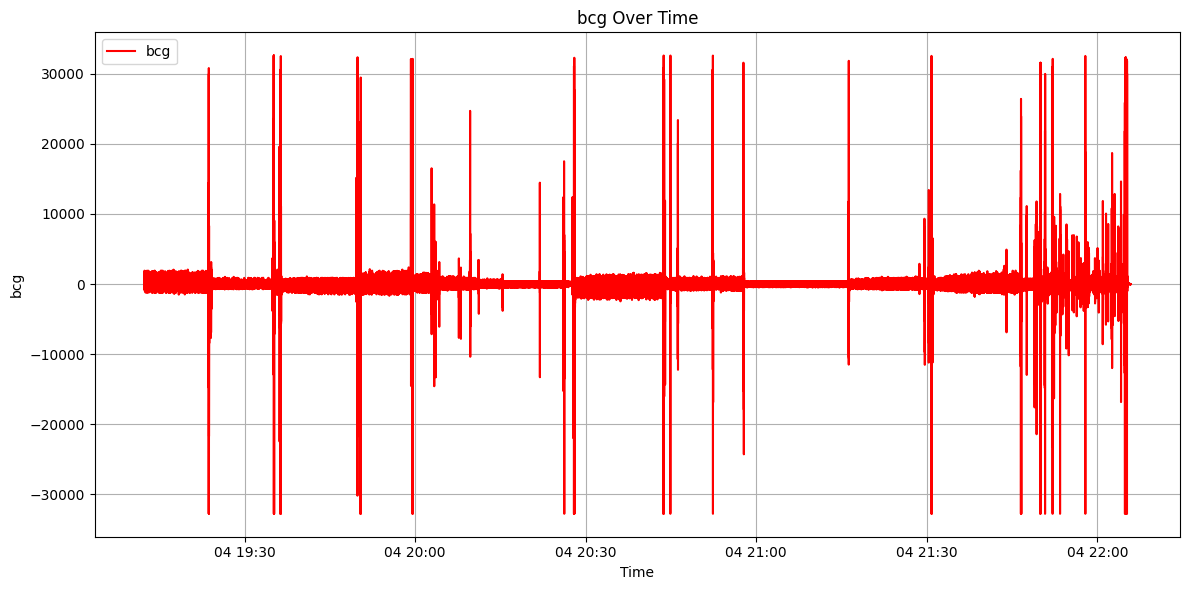

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(bcg_sync['Timestamp'], bcg_sync['BCG'], label='bcg', color='red')  # Assuming HR column is named 'HR'
plt.xlabel('Time')
plt.ylabel('bcg')
plt.title('bcg Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# construct window list

window_list = create_time_windows(bcg_sync, 'Timestamp', 'BCG', window_length_sec=10, shift_sec=10)
sample_counts = [len(window) for window in window_list]


In [10]:
print(len(window_list))

1041


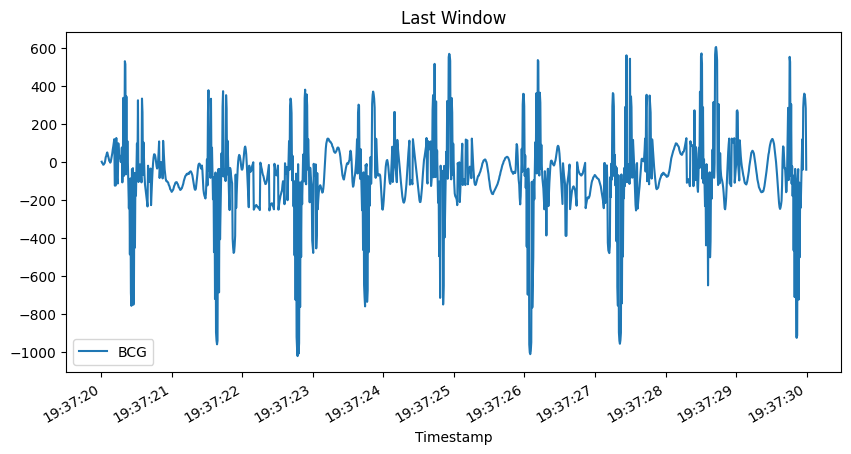

In [11]:

window_list[150].plot(x='Timestamp', y='BCG', title='Last Window', figsize=(10, 5))
plt.show()


In [19]:
pure_bcg = []
for i, window in enumerate(window_list):
    # Resample BCG signal to 50 Hz (for 10 seconds => 500 samples)
    resampled_to_50hz = resample_to_50hz(window['BCG'], target_fs=50, duration_sec=10)

    # Get start and end time of the current window
    t_start = window['Timestamp'].iloc[0]
    t_end = window['Timestamp'].iloc[-1]

    # Generate 500 timestamps linearly spaced between start and end
    resampled_times = pd.date_range(start=t_start, end=t_end, periods=500)

    resampled_df = pd.DataFrame({
        'Timestamp': resampled_times,
        'BCG': resampled_to_50hz,
    })

# Add 'Time' column in HH:MM:SS.ffffff format
    resampled_df['Time'] = resampled_df['Timestamp'].dt.strftime('%H:%M:%S.%f')

    pure_bcg.append(resampled_df)


In [22]:

# # Get the first level-4 approximation from pure_bcg
# approximation = pure_bcg[1000]

# # Plot
# plt.figure(figsize=(10, 4))
# plt.plot(approximation, color='green')
# plt.title('Level-4 Approximation of First BCG Window')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.tight_layout()
# plt.show
pure_bcg[0]

,Timestamp,BCG,Time
0,2023-11-04 19:12:20.003285714,-78.339138,19:12:20.003285
1,2023-11-04 19:12:20.023311479,-49.859255,19:12:20.023311
2,2023-11-04 19:12:20.043337245,-124.570451,19:12:20.043337
3,2023-11-04 19:12:20.063363011,-812.595526,19:12:20.063363
4,2023-11-04 19:12:20.083388777,-412.257564,19:12:20.083388
...,...,...,...
495,2023-11-04 19:12:29.916039793,-63.723056,19:12:29.916039
496,2023-11-04 19:12:29.936065559,-45.033940,19:12:29.936065
497,2023-11-04 19:12:29.956091325,-47.094662,19:12:29.956091
498,2023-11-04 19:12:29.976117091,-23.860417,19:12:29.976117


/home/bahey/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bahey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bahey/.local/lib/python3.10/site-packages/numpy/ma/core.py:5334: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/bahey/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bahey/.local/lib/python3.10/site-packages/heartpy/visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


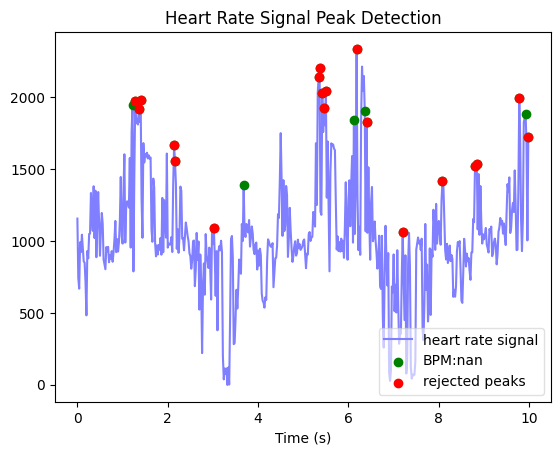

In [15]:
# heartpy ??

wd, m = hp.process(pure_bcg[150]['BCG_Approx_L4'], sample_rate=50)

# Plot results
hp.plotter(wd, m)

In [21]:
### Onto the heart rate

hr_sync['Timestamp'] = pd.to_datetime(hr_sync['Timestamp'])

# Set Timestamp as the index
hr_sync.set_index('Timestamp', inplace=True)

# Group by non-overlapping 10-second windows and calculate the mean of 'Heart Rate'
windowed_df = hr_sync.resample('10S').mean()

# Print the result
print(windowed_df[['Heart Rate']])


                     Heart Rate
Timestamp                      
2023-11-04 19:12:20   98.687500
2023-11-04 19:12:30  100.625000
2023-11-04 19:12:40   94.066667
2023-11-04 19:12:50   92.625000
2023-11-04 19:13:00   92.000000
...                         ...
2023-11-04 22:05:10   59.300000
2023-11-04 22:05:20   60.300000
2023-11-04 22:05:30   60.100000
2023-11-04 22:05:40   59.800000
2023-11-04 22:05:50   59.500000

[1042 rows x 1 columns]


/tmp/ipykernel_5204/1140297213.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  windowed_df = hr_sync.resample('10S').mean()


0      22:05:40.003285
1      22:05:40.023311
2      22:05:40.043337
3      22:05:40.063363
4      22:05:40.083388
            ...       
495    22:05:49.916039
496    22:05:49.936065
497    22:05:49.956091
498    22:05:49.976117
499    22:05:49.996142
Name: Time, Length: 500, dtype: object
0      -2.869317
1      -7.935901
2      -6.296811
3      -1.886218
4       0.028115
         ...    
495    12.350859
496     8.719952
497     5.563190
498     2.394187
499     3.874235
Name: BCG, Length: 500, dtype: float64
[ 6.02590948e-01  5.91256074e-01  5.75039639e-01  5.54382358e-01
  5.29793956e-01  5.01836365e-01  4.71105365e-01  4.38211872e-01
  4.03764330e-01  3.68353459e-01  3.32540147e-01  2.96846718e-01
  2.61751352e-01  2.27685235e-01  1.95031969e-01  1.64128811e-01
  1.35269235e-01  1.08706067e-01  8.46539876e-02  6.32911988e-02
  4.47604716e-02  2.91693843e-02  1.65893579e-02  7.05317104e-03
  5.51010357e-04 -2.97437105e-03 -3.63238924e-03 -1.58812424e-03
  2.93633466e-03  9.6630984

/home/bahey/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


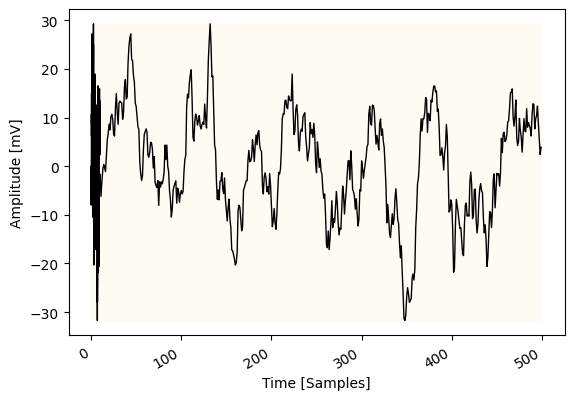

In [24]:
bcg= pure_bcg[1040]
start_point, end_point, window_shift, fs = 0, 500, 500, 50
utc_time = bcg['Time']
data_stream = bcg['BCG']
print(utc_time)
print(data_stream)
data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
movement = band_pass_filtering(data_stream, fs, "bcg")
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
print(wavelet_cycle)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)

print("ehhhhhhh")
print(beats)
print(np.around(np.mean(beats)))
# if len(beats) > 0:
#     print(np.around(np.mean(beats)))
#     .append(np.aroundaverage_from_bcg(np.mean(beats)))
# else:
#     average_from_bcg.append(np.nan)


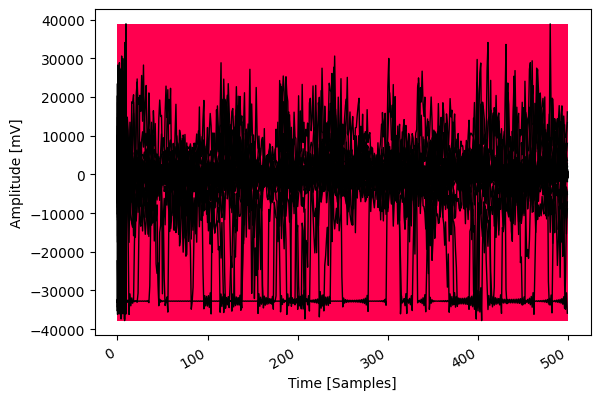

In [26]:
average_from_bcg = []
for i, bcg in enumerate(pure_bcg):
    start_point, end_point, window_shift, fs = 0, 500, 500, 50
    utc_time = bcg['Timestamp']
    data_stream = bcg['BCG']
    data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
    movement = band_pass_filtering(data_stream, fs, "bcg")
    breathing = band_pass_filtering(data_stream, fs, "breath")
    breathing = remove_nonLinear_trend(breathing, 3)
    breathing = savgol_filter(breathing, 11, 3)
    w = modwt(movement, 'bior3.9', 4)
    dc = modwtmra(w, 'bior3.9')
    wavelet_cycle = dc[4]
    t1, t2, window_length, window_shift = 0, 500, 500, 500
    hop_size = math.floor((window_length - 1) / 2)
    limit = int(math.floor(breathing.size / window_shift))
    beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
    if len(beats) > 0:
        print(np.around(np.mean(beats)))
        average_from_bcg.append(np.around(np.mean(beats)))
    else:
        average_from_bcg.append(np.nan)


In [27]:

# Convert the list to a DataFrame
df = pd.DataFrame({'Average_BCG': average_from_bcg})

# Save to CSV
df.to_csv('average_bcg.csv', index=False)